In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# 1. マルコフ決定過程
---
### 1-1. 環境
強化学習は教師あり学習とは異なり、データを用いません。
代わりに**環境(Environment)**が与えられると考えます。
ここでは事前に
* https://github.com/AkinoriTanaka-phys/HPC-Phys_tutorial_and_hands-on/blob/master/maze.py

に用意した迷路の環境を使って、実装に沿った説明を試みます。
まずは迷路の環境を読み込んでみましょう：

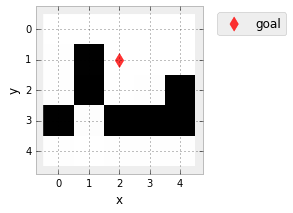

In [3]:
from maze import MazeEnv
Env = MazeEnv(5,5, threshold=1., figsize=3) # threshold が大きいほど簡単な迷路
Env.render()

**`Env.render()`**は環境を表示させる関数です。環境の関数名はなるべく<a href="https://gym.openai.com">OpenAI Gym</a>を参考にしました。
> **【補足】** <a href="https://gym.openai.com">OpenAI Gym</a> はAtari社のブロック崩しゲームを始めとした、数々のゲームやその他の強化学習環境をpythonから呼び出すためのライブラリで、無料です。pipコマンドでダウンロードできます。

ここで
* ◾は通れない壁
* ◆ は迷路のゴール地点

を表すとします。早速この迷路のスタート地点に「プレイヤー」を置いてみましょう：


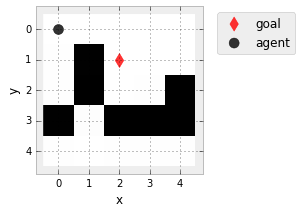

In [5]:
Env.reset() # 迷路の形はそのまま、ランダムなスタート地点にプレイヤー＝エージェントを置くコマンド
Env.render()

 ● が追加されました。これがプレイヤーの位置を表します。その座標(**状態(state)**といいます)は以下で確認できます：

In [6]:
Env.get_state() # array([x座標, y座標])が出力されます

array([0, 0])

プレイヤーは [↑、↓、←、→] を各座標で選択します。これを**行動(action)**と言います。行動のリストは：

In [7]:
Env.action_space

[0, 1, 2, 3]

後の便宜のため、[↑、↓、←、→] は `[0, 1, 2, 3]` で表現しています：

In [8]:
a2m = {0:'up', 1:'down', 2:'left', 3:'right'}
# 打ち込むのが面倒な場合は以下
from maze import a2m

試しに ● を動かしてみましょう。それぞれ
* `Env.step0(s, a)`：**状態:`s`**に居るときに**行動:`a`**を取ったときの次の**状態**を返す
* `Env.step1(s, a, next_s)`：**状態:`s`**に居るときに**行動:`a`**を取り、**状態:`next_s`**に移った時の「**報酬(reward)**」の値を返す

時刻1, [0 0]->[1 0], by right-move, reward=0


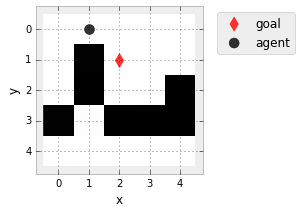

In [9]:
a = 3
s = Env.get_state()
##### 
next_s = Env.step0(s, a)
next_r = Env.step1(s, a, next_s)
Env.state = next_s # Env の内部状態を更新
#####
print("時刻{}, {}->{}, by {}-move, reward={}".format(Env.t, s, next_s, a2m[a], next_r))
Env.render()

真ん中の3行を毎回書くのは面倒なので
* `Env.step(a)`：上２つを同時に実行し、(**状態:`next_s`**, **報酬:`next_r`**, 解けたかどうか, 補足)を返す

を用意しました：

時刻2, [1 0]->[1 0], by up-move, reward=0


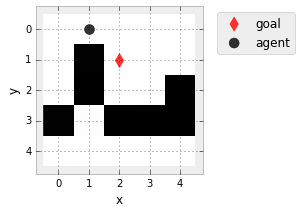

In [10]:
a = 0
s = Env.get_state()
#####
next_s, next_r, _, _ = Env.step(a) 
#####
print("時刻{}, {}->{}, by {}-move, reward={}".format(Env.t, s, next_s, a2m[a], next_r))
Env.render()

### ● ここまでのまとめ
- 登場する集合とその要素
 - **時刻**(状態、報酬、行動の添字) <br> $\quad T=\{0,1,2,3, \dots\}=\{t\}$<br/>
 - **状態**のとり得る集合（迷路だとプレイヤーのとり得るすべての座標\{`(x, y)`\}）<br/> $\quad S=\{s\}$<br/>
 - **報酬**の集合（迷路だと\{`0, 1`\} = \{解けてない, 解けた \}）<br/> $\quad R=\{r\}$<br/>
 - **行動**の集合（迷路だと\{`0, 1, 2, 3` \} = \{↑, ↓, ←, → \}）<br/> $\quad A=\{a\}$

- **環境**の持つ性質 (実装上は`Env.step(a)`で同時に計算)
 - $s_{t+1} = \text{step}_0(s_t, a_t)$
 - $r_{t+1} = \text{step}_1(s_t, a_t, s_{t+1})$

### ● より一般の環境について

上に書いた$\text{step}_{0, 1}$は関数なので、入力値が定まれば出力値は確定しています。
しかし、一般にはこれらが確定していない場合もあります。
> **【補足】** 例えば囲碁の盤面の**状態**とその時に置いた碁石の位置（**行動**）が何らかの具体的な値$(s_t, a_t)$を取ったからと言って、相手がどう出るかわからないので、次の自分の番での**状態** $s_{t+1}$が確定しているわけではありません。

このような場合も考慮に入れるために、確率的な定式化を導入します。P(x)から実際に値をサンプリングすることを

$$ x \sim P(x) $$

と書くことにすると、$P_s, P_r$をそれぞれ状態と報酬が与えられる確率だとして、
- **環境**の持つ性質(一般)
 - $s_{t+1} \sim P_s(s_{t+1}|s_t, a_t)$
 - $r_{t+1} \sim P_r(r_{t+1}|s_t, a_t, s_{t+1})$

と書けます。迷路のように決定している場合はデルタ関数などで表現できます。

---
### 1-2. エージェント
ここまでは手で操作してきました。つまり
* エージェント＝あなた自身

だったわけです。

あなた自身が迷路ゲームをプレイするとき、気分によって同じ座標に居ても↑だったり↓だったり選択するので、ゲームのプレイ方針は確率的といえるでしょう。このような「エージェントが持っているゲームのプレイ方針を記述する確率」を**方策(Policy)**といいます。

あなた自身の何らかの**方策**に基づいてエージェントを操作していたわけですが、強化学習ではその部分を機械に置き換えたいわけです。そうすると、機械のエージェントの実装に必要なのは**方策** と、それに従うゲームのプレイ＝**行動**のサンプリング、ですから

In [11]:
class Agent():
    def __init__(self, Policy):
        self.Policy = Policy
        
    def play(self):
        """
        return a number in [0,1,2,3] corresponding to [up, down, left, right]
        """
        return self.Policy.sample()

のような実装になるでしょう。ここで**方策**も何らかの条件付き確率で与えられることを前提としています：

- エージェントが持つべき性質
 - **方策**をあらわす条件付き確率<br/> $\quad \pi(a_t|s_t)$<br/>
 - そこからのサンプリング<br/> $\quad a_t \sim \pi(a_t|s_t)$<br/>


**`Policy`** はこの確率を記述するオブジェクトであり、**`Policy.sample()`**はサンプリングを記述するものです。

従って **`Policy`** は **`sample()`** 関数を持った何らかのオブジェクトとして

In [12]:
class Policy():
    def __init__(self):
        pass
    
    def sample(self):
        """
        プロトタイプなので pass とか適当でいいですが、後に
        [0,1,2,3] = [up, down, left, right] から一つ数を返す用に実装
        """
        action = None
        return action

のようなものを想定しています。たとえば、完全にランダムな方策

$$
\pi_\text{random}(a|s)
=
\frac{1}{|A|},
\quad
A = \{a\}
$$

は

In [13]:
class Random(Policy):
    def __init__(self, Env):
        self.A = Env.action_space # 迷路だと[0, 1, 2, 3]
        
    def sample(self):
        return np.random.choice(self.A) # np.random.choice(リスト)：リストから1つの要素をランダムサンプル

のように書けます。実際にこの方策を用いてゲームを1回プレイさせてみます：

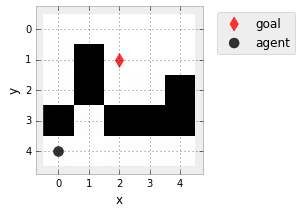

right


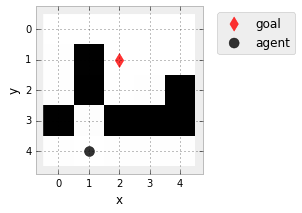

In [19]:
Agt = Agent(Policy=Random(Env)) # Random方策に基づく機械エージェント
Env.reset()
Env.render()

action = Agt.play()
print(a2m[action])
Env.step(action)
Env.render()

---
### 1-3. マルコフ決定過程

ここまでで
* **環境**：$\{ P_s(s_{t+1}|s_t, a_t), \ P_r(r_{t+1}|s_t, a_t, s_{t+1})\}$ = \{**状態**の時間発展,  **即時報酬**の時間発展 \}
* **エージェント**：$\{ \pi(a_t|s_t)\}$ = \{ **行動**の時間発展 \}

と3種類の確率変数$\{ s, r, a\}$についての時間発展を定義してきました。強化学習では、この3種類の確率変数の時間発展をゲームが終わるまで行います：

$$
\left. \begin{array}{ll:ll:ll:ll}
s_0 
\overset{\pi(\cdot|s_0)}{\to}
&
a_0 
\overset{P_s(\cdot|s_0, a_0)}{\to} 
&
s_1 
&
\overset{\pi(\cdot|s_1)}{\to}
a_1  
\overset{P_s(\cdot|s_1, a_1)}{\to} 
&
s_2
&
\overset{\pi(\cdot|s_2)}{\to}
a_2
\overset{P_s(\cdot|s_2, a_2)}{\to} 
&
 \cdots
\\
\downarrow_{P_r(\cdot|-, -, s_0)} 
&&
\downarrow_{P_r(\cdot|s_0, a_0, s_1)} 
&&
\downarrow_{P_r(\cdot|s_1, a_1, s_2)} 
\\
r_0
&
&
r_1
&
&
r_2
\end{array} \right.
\tag{1.3}
$$

これを**マルコフ決定過程(Markov Decision Process, MDP)**といいます。


ゲームが始まってから終わるまでの1単位（**MDP**の1つのサンプル系列）を**エピソード(episode)**と呼びます。

強化学習の理論的な部分は主にこの**MDP**に基づいた確率論で記述されます。

<IPython.core.display.Javascript object>


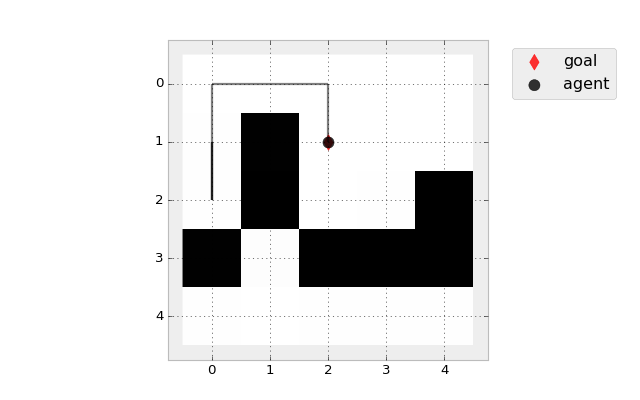

solved!


In [20]:
# 迷路のMDPから1エピソードサンプル再生
Agt = Agent(Policy=Random(Env)) # Random方策に基づく機械エージェント
Env.reset()
%matplotlib notebook 
Env.play_interactive(Agt)
%matplotlib inline

In [21]:
Env.t # 苦戦しすぎ

18